In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization

import logging

import torch

import importlib
import glob
import numpy as np
import plot_results as pltr
import F21DataLoader as dl
import f21_predict_base as base
import F21Stats as f21stats
import importlib

importlib.reload(dl)
importlib.reload(base)
importlib.reload(f21stats)
importlib.reload(pltr)

logger = logging.getLogger(__name__)

def load_dataset(datafiles, psbatchsize=1, ps_bins=None, limitsamplesize=None, input_points=None):
    # Create processor with desired number of worker threads
    processor = dl.F21DataLoader(max_workers=1, psbatchsize=psbatchsize, skip_ps=True, ps_bins=None, limitsamplesize=limitsamplesize)#, limitsamplesize=4)
        
    # Process all files and get results 
    results = processor.process_all_files(datafiles)
        
    # Access results
    #print(f'{results.keys()}')
    #all_ks = results['ks']
    all_los = results['los']
    print(f'Loaded los shape={all_los.shape}')
    all_freq = results['freq_axis']
    if input_points is not None: 
        all_los = all_los[:,:input_points]
        all_freq = all_freq[:,:input_points]
    #all_ps = results['ps']
    #ps_std = results['ps_std']
    #ps_plus_std = all_ps + ps_std
    #ps_minus_std = all_ps - ps_std
    #all_params = results['params']
    #plot_los(all_ps[0], freq_axis)
    """
    print(f"sample ks:{all_ks[0]}")
    print(f"sample ps:{all_ps[0,:]}")
    print(f"sample params:{all_params[0]}")
    print(f"sample los:{all_los[0]}")
    print(f"sample freq:{all_freq}")
    """
    #base.plot_los(all_los[:1], all_freq[0,:], showplots=True, saveplots = False, label=f"{all_params[0]}")
    #base.plot_power_spectra(all_ps[:1], all_ks[:1], all_params[:1], showplots=True, saveplots = False, label=f"{all_params[0]}")

    print(f"\nCombined data shape: {all_los.shape}")
    #print(f"Combined parameters shape: {all_params.shape}")
    return (all_los, all_freq)

In [4]:
g50denoisedfilepath = '../data/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
print(f"shape:{los1052.shape}")
los1052so, freq_axis = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52*.dat"), limitsamplesize=2560)
print(f"shape:{los1052so.shape}")
los1052noisy, _ = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
print(f"shape:{los1052noisy.shape}")
pltr.plot_denoised_los(los1052noisy[10:11], los1052so[10:11], los1052[10:11], showplots=True, saveplots=False, label=r'$\langle xHI\rangle$=0.52, log$_{10}(f_X)$=-1.0', freq_axis=freq_axis[0]/1e6)

FileNotFoundError: ../data/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv not found.

shape:(20, 2560)

Combined data shape: (1000, 2560)
shape:(1000, 2560)

Combined data shape: (1000, 2560)
shape:(1000, 2560)


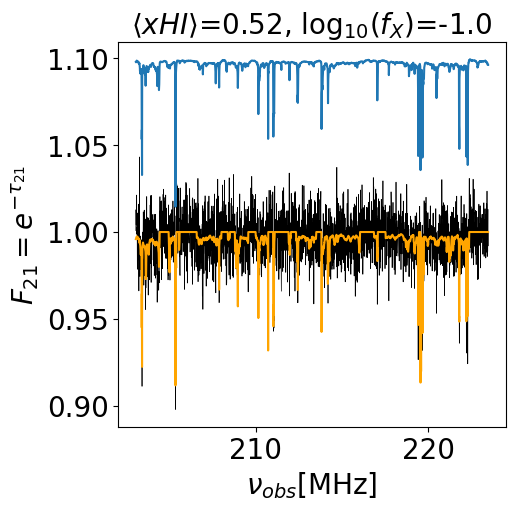

denoising $\langle xHI\rangle$=0.52, log$_{10}(f_X)$=-1.0: χ²=0.36 χ²=0.03


In [39]:
g50denoisedfilepath = '../data/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
print(f"shape:{los1052.shape}")
los1052so, freq_axis = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.52*.dat"), limitsamplesize=2560)
print(f"shape:{los1052so.shape}")
los1052noisy, _ = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
print(f"shape:{los1052noisy.shape}")
pltr.plot_denoised_los(los1052noisy[10:11], los1052so[10:11], los1052[10:11], showplots=True, saveplots=False, label=r'$\langle xHI\rangle$=0.52, log$_{10}(f_X)$=-1.0', freq_axis=freq_axis[0]/1e6)

In [158]:
from matplotlib.ticker import FuncFormatter
def axformat(x, pos):
    # x:  tick value - ie. what you currently see in yticks
    # pos: a position - ie. the index of the tick (from 0 to 9 in this example)
    return '%.1f' % x

def plot_comb_denoised_los(los_test, y_test_so, y_pred_so, samples=1, showplots=False, saveplots=True, output_dir='tmp_out', x=None, f=None,freq_axis=None):
    label=rf'$\langle xHI\rangle$={x:.2f}, log$f_X$={f:.1f}'
    fsize = 12
    plt.rcParams['axes.titlesize'] = fsize
    plt.rcParams['axes.labelsize'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize
    plt.rcParams['ytick.labelsize'] = fsize
    plt.rcParams['legend.fontsize'] = fsize
    #plt.figure(figsize=(10.,5.))
    #plt.title(f'{label}')

    fig, axes = plt.subplots(3, 1, figsize=(6., 4.), sharex=True, gridspec_kw={'hspace': 0.04})

    for i, (axs, los, label, title) in enumerate(zip(axes, [y_test_so, los_test, y_pred_so], 
                                              [r'$F_{21}^{\rm S}$', r'$F_{21}^{\rm S+N}$', r'$F_{21}^{\rm D}$'],
                                              ['True Signal', 'Noisy Signal', 'Denoised Signal'])):
        print(f'{label}, los.shape={los.shape}')

        if freq_axis is None: freq_axis=range(len(los))
             # Enable minor ticks
        axs.minorticks_on()

        # Customize major ticks
        axs.tick_params(
                which='major',
                direction='in',
                length=10,
                width=1,
                #labelsize=12,
                top=True,
                bottom=True,
                left=True,
                right=True
            )

        # Customize minor ticks
        axs.tick_params(
                which='minor',
                direction='in',
                length=5,
                width=1,
                top=True,
                bottom=True,
                left=True,
                right=True
            )
        #chisq_noisy = np.sum((noisy - test)**2 / test)
        axs.plot(freq_axis[:2560], los[0,:2560], c='black', linewidth=1, label=f'{label}') #label=f'Signal+Noise: χ²={chisq_noisy:.2f}', 
        #axs_formatter = FuncFormatter(axformat)
        #axs.yaxis.set_major_formatter(axs_formatter)
        
        #axs.set_yticklabels(["1.0"])

        #axs.set_xticks(np.arange(0.,0.9,0.2))
        axs.set_yticks(np.arange(0.8,1.04,0.1))

        axs.set_ylim(0.82, 1.05)
        
        #axs.set_xlim(205, 215)
        axs.set_ylabel(label)
        """
        axs.text(
            217.5, 0.86,  # x, y position
            title,
            fontsize=fsize,
            color='black',
            bbox=dict(
                facecolor='white',   # Background color
                alpha=0.5,           # Transparency (0=fully transparent, 1=opaque)
                edgecolor='white'    # Optional border
            )
        )
        """

        axs.text(
            .95, 0.25, title,
            ha='right', va='center',
            transform=axs.transAxes,           
            fontsize=fsize,
            color='black',
            bbox=dict(
                facecolor='white',   # Background color
                alpha=0.5,           # Transparency (0=fully transparent, 1=opaque)
                edgecolor='white'    # Optional border
            )
        )
        #plt.legend(loc='best')#lower right')
        #print(f'denoising {label}: χ²={chisq_noisy:.2f} χ²={chisq_denoised:.2f}')
        #axs.legend(loc='lower right', frameon=False)
    axes[2].set_xlabel(r'$\nu_{obs}$[MHz]')
    #fig.supylabel(r'$F_{21}=e^{-\tau_{21}}$')
    
    #fig.subplots_adjust(wspace=0., hspace=0.)
    #plt.tight_layout()
    #axes[1].legend(loc='lower center', title='log$_{10}(f_X)$=-2.0', title_fontsize=20)
    if saveplots: 
        plt.savefig(f"{output_dir}/denoised_flux_comb.pdf", format="pdf", bbox_inches='tight')
        logger.info(f"Saved denoised los plot to {output_dir}/denoised_flux_comb.pdf")


    if showplots: plt.show()
    plt.close()

shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2762)
shape:(1000, 2762)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2762)
shape:(1000, 2762)
$F_{21}^{\rm S}$, los.shape=(1, 2762)
$F_{21}^{\rm S+N}$, los.shape=(1, 2762)
$F_{21}^{\rm D}$, los.shape=(1, 2560)


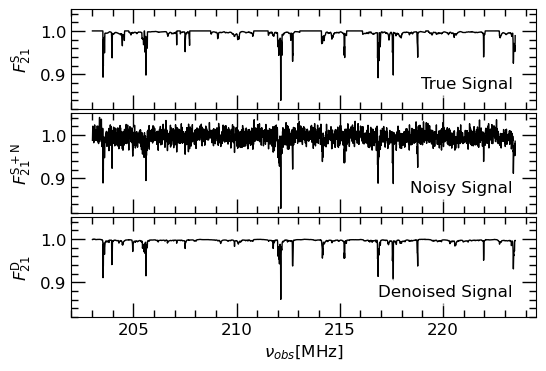

In [159]:
datapath = '../../../21cm-forest/data'
g50denoisedfilepath = f'{datapath}/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.80_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
print(f"shape:{los1052.shape}")
los1052so, freq_axis = load_dataset(glob.glob(f"{datapath}/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.80*.dat"), limitsamplesize=2560)
print(f"shape:{los1052so.shape}")
los1052noisy, _ = load_dataset(glob.glob(f"{datapath}/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.80_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
print(f"shape:{los1052noisy.shape}")
plot_comb_denoised_los(los1052noisy[10:11], los1052so[10:11], los1052[10:11], showplots=True, saveplots=True,freq_axis=freq_axis[0]/1e6, x=0.52, f=-2.0)

shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.11_-1.0.pdf


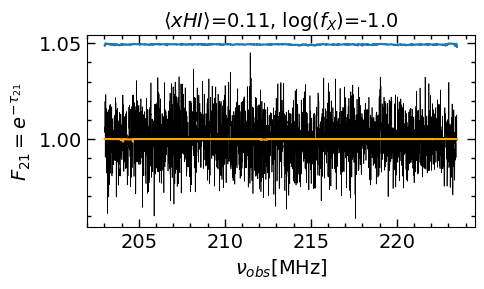

denoising $\langle xHI\rangle$=0.11, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.11_-2.0.pdf


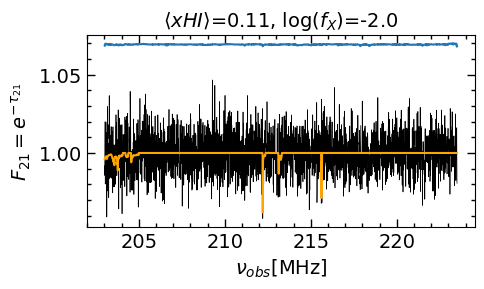

denoising $\langle xHI\rangle$=0.11, log$(f_X)$=-2.0: χ²=0.38 χ²=0.01
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.11_-3.0.pdf


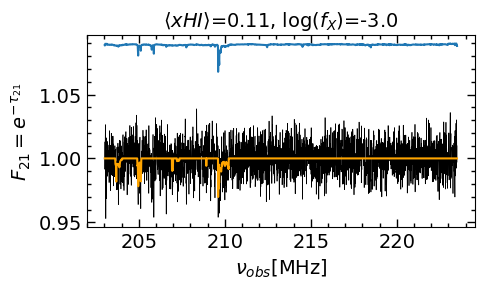

denoising $\langle xHI\rangle$=0.11, log$(f_X)$=-3.0: χ²=0.38 χ²=0.01
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.25_-1.0.pdf


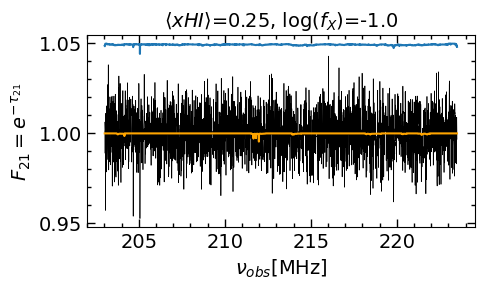

denoising $\langle xHI\rangle$=0.25, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.25_-2.0.pdf


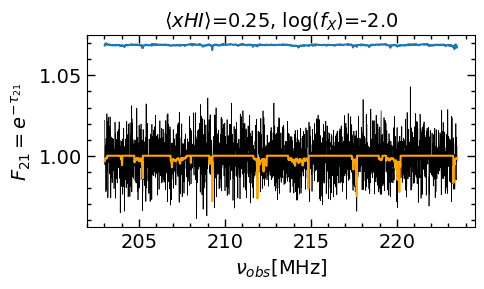

denoising $\langle xHI\rangle$=0.25, log$(f_X)$=-2.0: χ²=0.34 χ²=0.01
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.25_-3.0.pdf


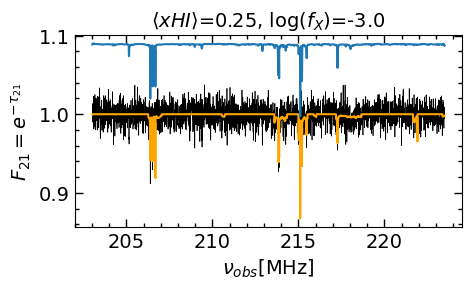

denoising $\langle xHI\rangle$=0.25, log$(f_X)$=-3.0: χ²=0.39 χ²=0.02
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.52_-1.0.pdf


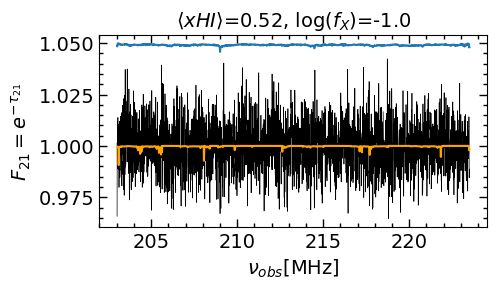

denoising $\langle xHI\rangle$=0.52, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.52_-2.0.pdf


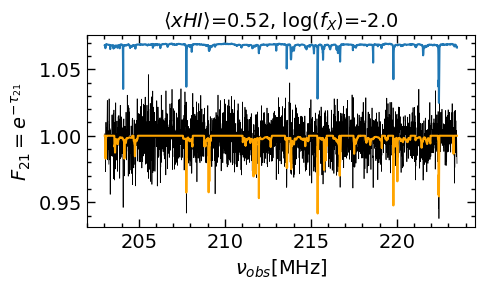

denoising $\langle xHI\rangle$=0.52, log$(f_X)$=-2.0: χ²=0.39 χ²=0.02
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.52_-3.0.pdf


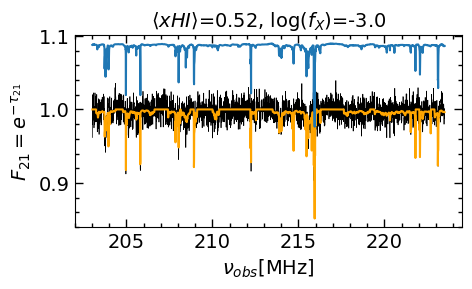

denoising $\langle xHI\rangle$=0.52, log$(f_X)$=-3.0: χ²=0.35 χ²=0.04
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


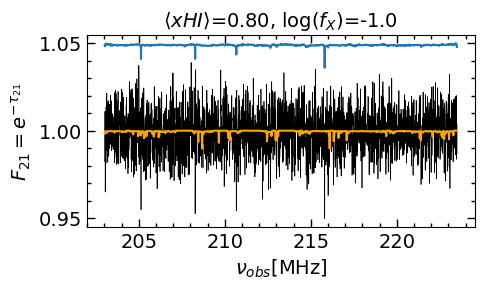

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.38 χ²=0.00
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-2.0.pdf


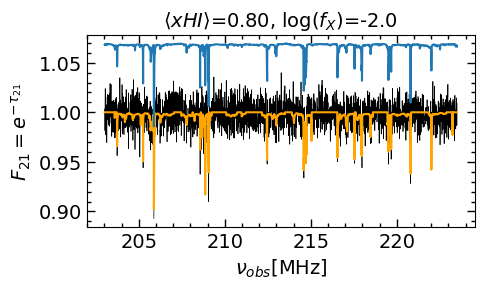

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-2.0: χ²=0.36 χ²=0.03
shape:(20, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
shape:(1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-3.0.pdf


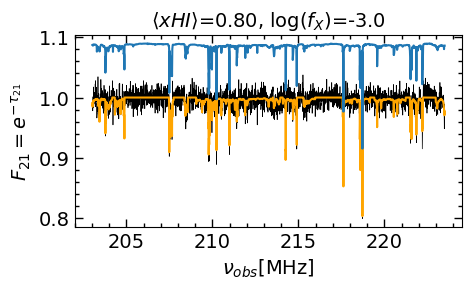

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-3.0: χ²=0.36 χ²=0.05


In [60]:
import plot_results as pltr
import importlib

importlib.reload(pltr)
data="../../../21cm-forest/data"
g50denoisedfilepath = f'{data}/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
xs=[0.11,0.25,0.52,0.80]
fs=[-1,-2,-3]
for x in xs:
    for f in fs:
        los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX{f:.2f}_xHI{x:.2f}_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
        print(f"shape:{los1052.shape}")
        los1052so, freq_axis = load_dataset(glob.glob(f"{data}/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX{f:.2f}_xHI{x:.2f}*.dat"), input_points=2560)
        print(f"shape:{los1052so.shape}")
        los1052noisy, _ = load_dataset(glob.glob(f"{data}/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX{f:.2f}_xHI{x:.2f}_uGMRT_8kHz_t50h*.dat"), input_points=2560)
        print(f"shape:{los1052noisy.shape}")
        pltr.plot_denoised_los(los1052noisy[8:9], los1052so[8:9], los1052[8:9], showplots=True, saveplots=True, x=x, f=f, freq_axis=freq_axis[0]/1e6)

i=0
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


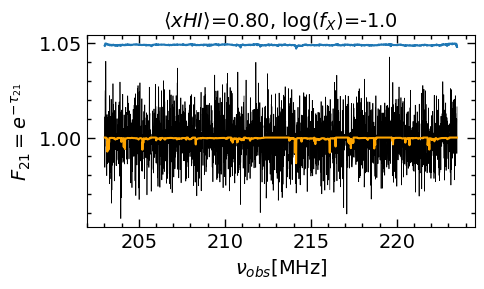

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=1
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


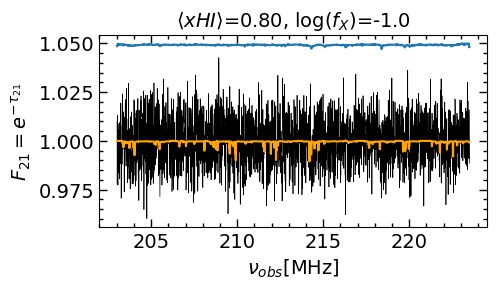

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.36 χ²=0.00
i=2
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


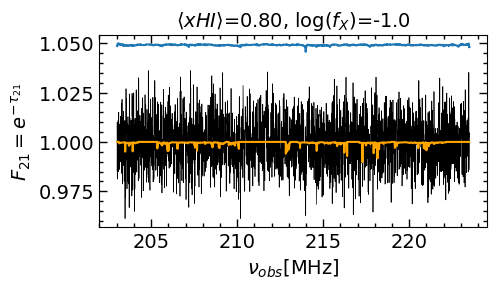

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=3
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


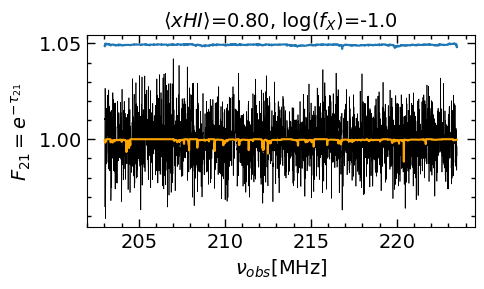

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.38 χ²=0.00
i=4
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


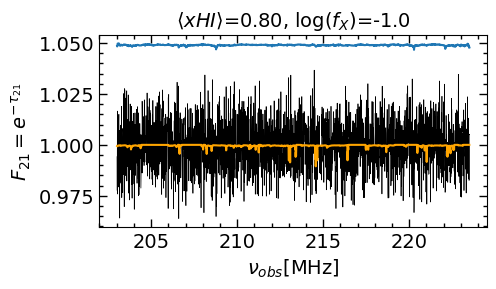

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.35 χ²=0.00
i=5
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


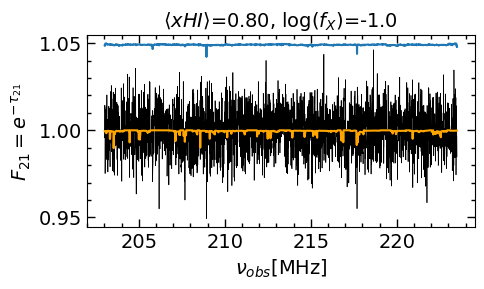

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.38 χ²=0.00
i=6
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


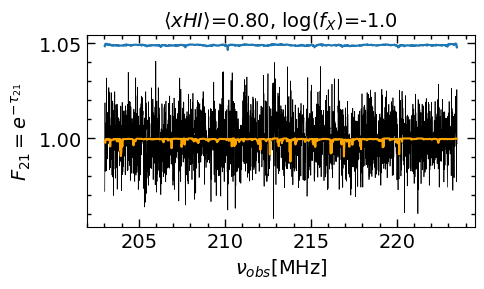

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=7
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


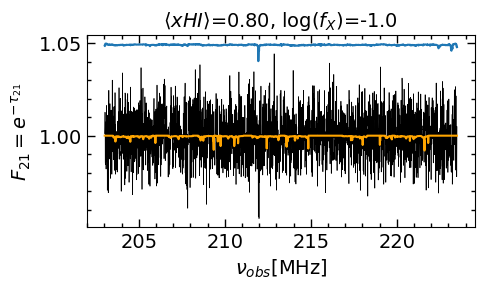

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=8
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


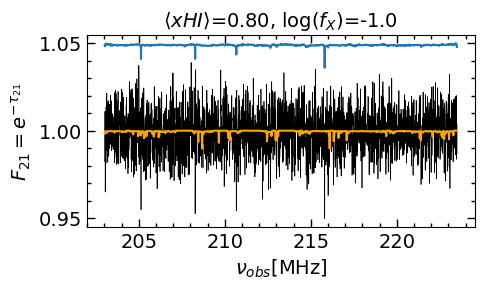

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.38 χ²=0.00
i=9
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


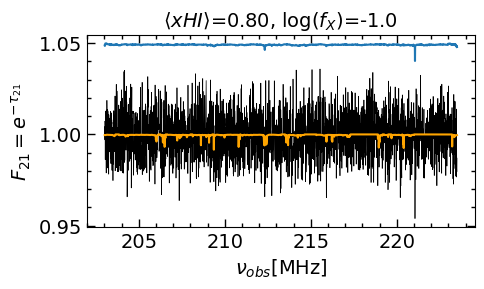

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.36 χ²=0.00
i=10
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


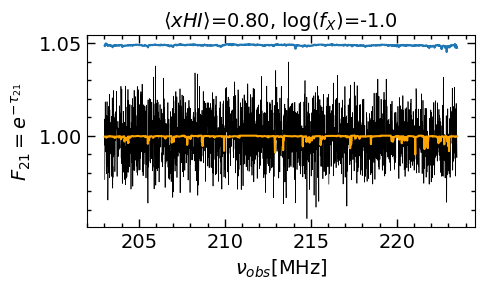

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.36 χ²=0.00
i=11
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


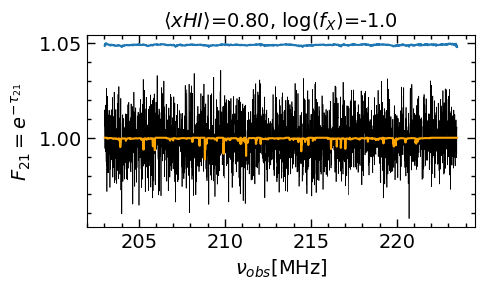

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.36 χ²=0.00
i=12
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


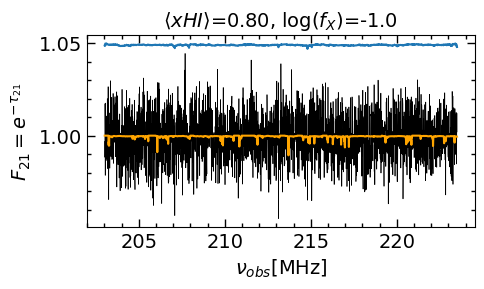

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.38 χ²=0.00
i=13
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


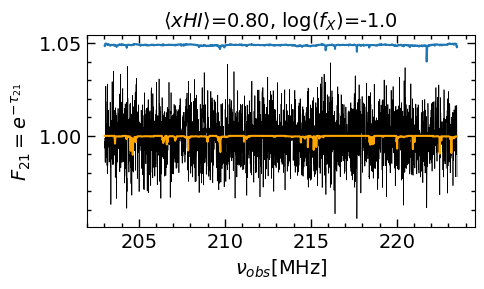

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.39 χ²=0.00
i=14
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


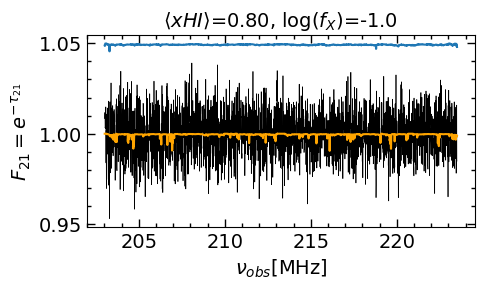

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=15
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


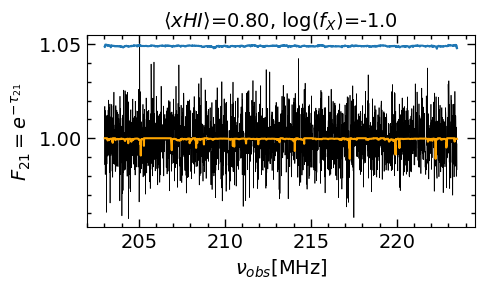

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.36 χ²=0.00
i=16
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


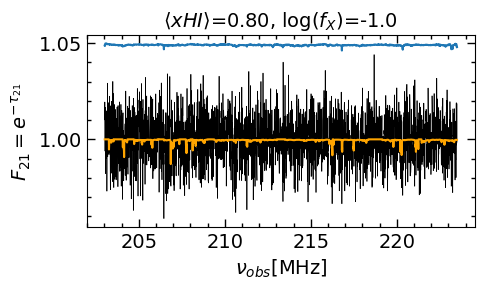

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.36 χ²=0.00
i=17
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


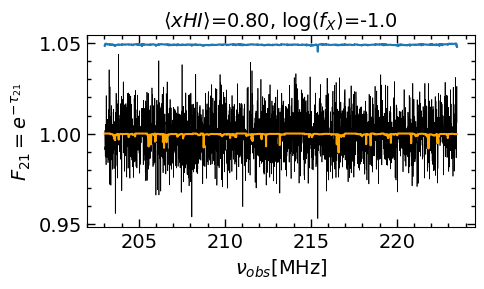

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=18
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


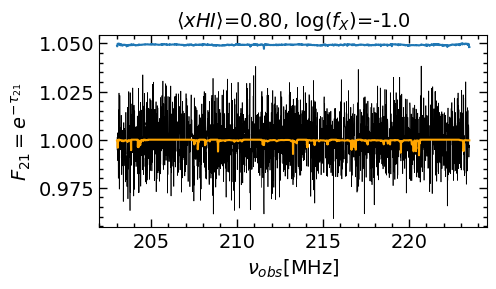

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00
i=19
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Saved denoised los plot to tmp_out/denoised_flux_0.80_-1.0.pdf


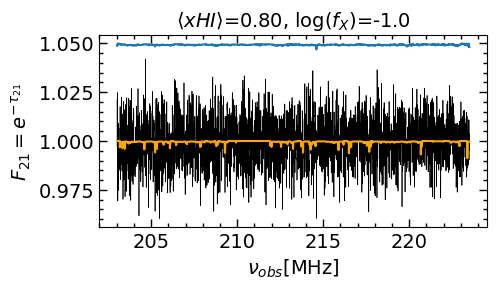

denoising $\langle xHI\rangle$=0.80, log$(f_X)$=-1.0: χ²=0.37 χ²=0.00


In [59]:
import plot_results as pltr
import importlib

importlib.reload(pltr)
data="../../../21cm-forest/data"
g50denoisedfilepath = f'{data}/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
x=0.80
f=-1
for i in range(20):
    print(f'i={i}')
    los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX{f:.2f}_xHI{x:.2f}_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
    #print(f"shape:{los1052.shape}")
    los1052so, freq_axis = load_dataset(glob.glob(f"{data}/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX{f:.2f}_xHI{x:.2f}*.dat"), input_points=2560)
    #print(f"shape:{los1052so.shape}")
    los1052noisy, _ = load_dataset(glob.glob(f"{data}/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX{f:.2f}_xHI{x:.2f}_uGMRT_8kHz_t50h*.dat"), input_points=2560)
    #print(f"shape:{los1052noisy.shape}")
    pltr.plot_denoised_los(los1052noisy[i:i+1], los1052so[i:i+1], los1052[i:i+1], showplots=True, saveplots=True, x=x, f=f, freq_axis=freq_axis[0]/1e6)

Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2560)


<Figure size 500x500 with 0 Axes>

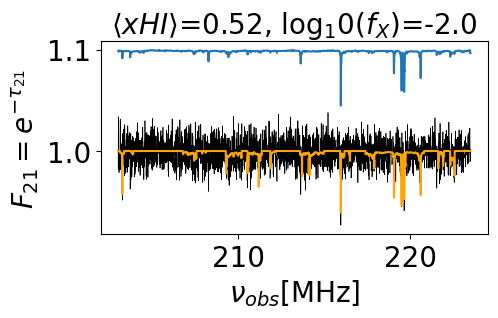

denoising $\langle xHI\rangle$=0.52, log$_10(f_X)$=-2.0: χ²=0.37 χ²=0.02


In [29]:
data="../../../21cm-forest/data"
g50denoisedfilepath = f'{data}/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1052so, freq_axis  = load_dataset(glob.glob(f"{data}/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52*.dat"), input_points=2560)
los1052noisy, _ = load_dataset(glob.glob(f"{data}/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), input_points=2560)

pltr.plot_denoised_los(los1052noisy, los1052so, los1052, showplots=True, saveplots=True, x=0.52, f=-2.0, freq_axis=freq_axis[0]/1e6)

In [118]:
def plot_los(los_test, samples=1, showplots=False, saveplots=True, label='', output_dir='tmp_out', freq_axis=None):
    
    for i, (noisy) in enumerate(los_test[:samples]):
        if freq_axis is None: freq_axis=range(len(noisy))
        
        plt.rcParams['figure.figsize'] = [5., 2.]
        plt.figure(frameon=True)

        #plt.title(f'{label}')
        #chisq_noisy = np.sum((noisy - test)**2 / test)
        plt.plot(freq_axis, noisy, c='black', linewidth=2.)
        #plt.plot(freq_axis, test, label='Signal', c='orange')
        #chisq_denoised = np.sum((pred - test)**2 / test)
        #plt.plot(freq_axis, pred+0.1, label=f'Denoised+0.1: χ²={chisq_denoised:.2f}')
        #plt.xlabel(r'$\nu_{obs}$[MHz]'), 
        #plt.ylabel(r'$F_{21}=e^{-\tau_{21}}$')
        #plt.legend(loc='best')#lower right')
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        plt.ylim(0.92,1.05)
        plt.tight_layout()
        if saveplots: 
            plt.savefig(f"{output_dir}/reconstructed_los_{label}.pdf", format="pdf", bbox_inches='tight')
            logger.info(f"Saved denoised los plot to {output_dir}/reconstructed_los_{label}.png")
        if i> 5: break
        if showplots: plt.show()
        #print(f'denoising {label}: χ²={chisq_noisy:.2f} χ²={chisq_denoised:.2f}')
        plt.close()

Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2762)
Loaded los shape=(1000, 2762)

Combined data shape: (1000, 2762)


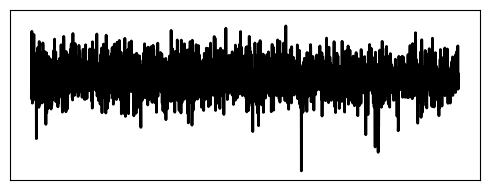

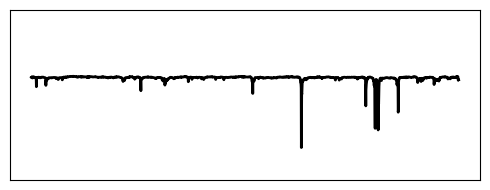

In [119]:
datapath = '../../../21cm-forest/data'
g50denoisedfilepath = f'{datapath}/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1052so, freq_axis  = load_dataset(glob.glob(f"{datapath}/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52*.dat"), limitsamplesize=2560)
los1052noisy, _ = load_dataset(glob.glob(f"{datapath}/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)

plot_los(los1052noisy[:,:2560], showplots=True, saveplots=True, label=rf'$\langle xHI\rangle$=0.52, log$_{10}(f_X)$=-2.0 noisy', freq_axis=freq_axis[0,:2560]/1e6)
#plot_los(los1052so, showplots=True, saveplots=True, label=r'$\langle xHI\rangle$=0.52, log$_{10}(f_X)$=-2.0', freq_axis=freq_axis[0]/1e6)
plot_los(los1052[:,:2560], showplots=True, saveplots=True, label=rf'$\langle xHI\rangle$=0.52, log$_{10}(f_X)$=-2.0 denoised', freq_axis=freq_axis[0,:2560]/1e6)

In [17]:
import matplotlib.pyplot as plt
def plot_denoised_los_comb(los_test_set, y_test_so_set, y_pred_so_set, showplots=False, saveplots=True, labels=None, output_dir='tmp_out', tag='', freq_axis=None):
    #print(f'los_test_set.shape={los_test_set.shape}')
    base.initplt()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, (axs, noisy, test, pred, label) in enumerate(zip(axes, los_test_set, y_test_so_set, y_pred_so_set, labels)):
        print(f'noisy.shape={noisy.shape}')

        if freq_axis is None: freq_axis=range(len(noisy))
        axs.set_title(f'{label}')
             # Enable minor ticks
        axs.minorticks_on()

        # Customize major ticks
        axs.tick_params(
                which='major',
                direction='in',
                length=10,
                width=1,
                #labelsize=12,
                top=True,
                bottom=True,
                left=True,
                right=True
            )

        # Customize minor ticks
        axs.tick_params(
                which='minor',
                direction='in',
                length=5,
                width=1,
                top=True,
                bottom=True,
                left=True,
                right=True
            )
        chisq_noisy = np.sum((noisy - test)**2 / test)
        axs.plot(freq_axis, noisy, c='black', linewidth=0.5) #label=f'Signal+Noise: χ²={chisq_noisy:.2f}', 
        axs.plot(freq_axis, test, c='orange') #, label='Signal',
        chisq_denoised = np.sum((pred - test)**2 / test)
        axs.plot(freq_axis, pred+0.05) # label=f'Denoised+0.1: χ²={chisq_denoised:.2f}'
        axs.set_xlabel(r'$\nu_{obs}$[MHz]'), 
        #axs.set_ylabel(r'$F_{21}=e^{-\tau_{21}}$')
        #plt.legend(loc='best')#lower right')
        print(f'denoising {label}: χ²={chisq_noisy:.2f} χ²={chisq_denoised:.2f}')
    
    axes[1].set_xlabel(r'$\nu_{obs}$[MHz]')
    axes[0].set_ylabel(r'$F_{21}=e^{-\tau_{21}}$')
    fig.subplots_adjust(right=1, wspace=0.02, hspace=0)
    #axes[1].legend(loc='lower center', title='log$_{10}(f_X)$=-2.0', title_fontsize=20)
    if saveplots: 
        plt.savefig(f"{output_dir}/denoised_flux{tag}.pdf", format="pdf", bbox_inches='tight')
        logger.info(f"Saved denoised los plot to {output_dir}/denoised_flux_{tag}.pdf")


    if showplots: plt.show()
    plt.close()




Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)
los1080.shape=(20, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.80: χ²=0.37 χ²=0.00
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.52: χ²=0.36 χ²=0.00
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.25: χ²=0.35 χ²=0.00


<Figure size 500x500 with 0 Axes>

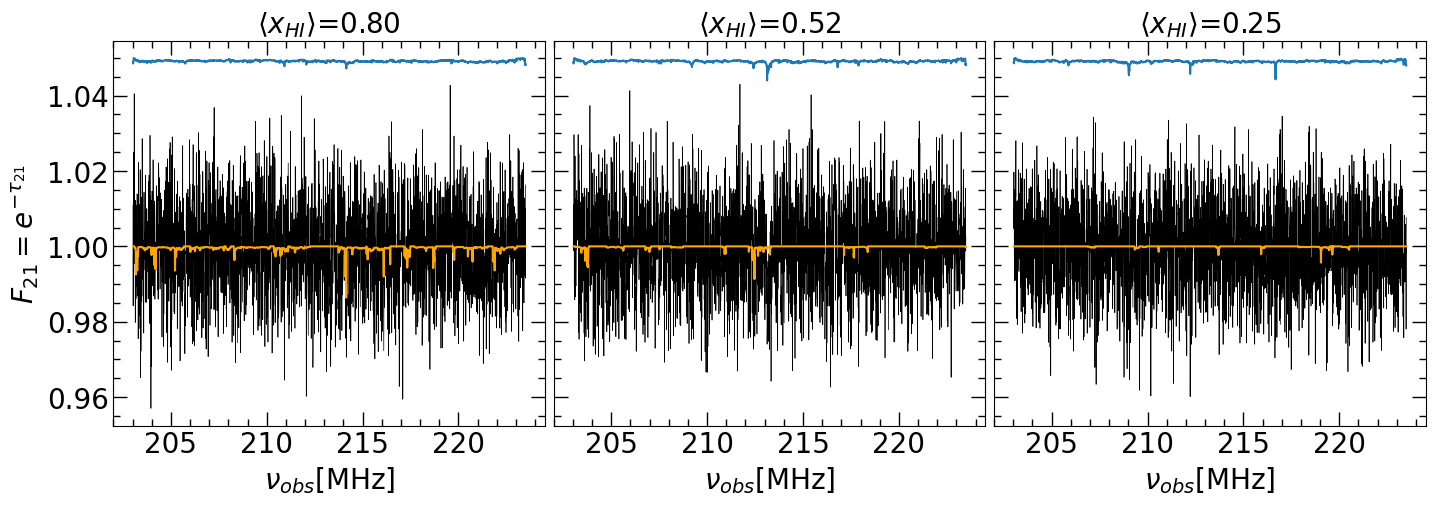


Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)
los1080.shape=(20, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.80: χ²=0.36 χ²=0.04
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.52: χ²=0.37 χ²=0.02
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.25: χ²=0.37 χ²=0.01


<Figure size 500x500 with 0 Axes>

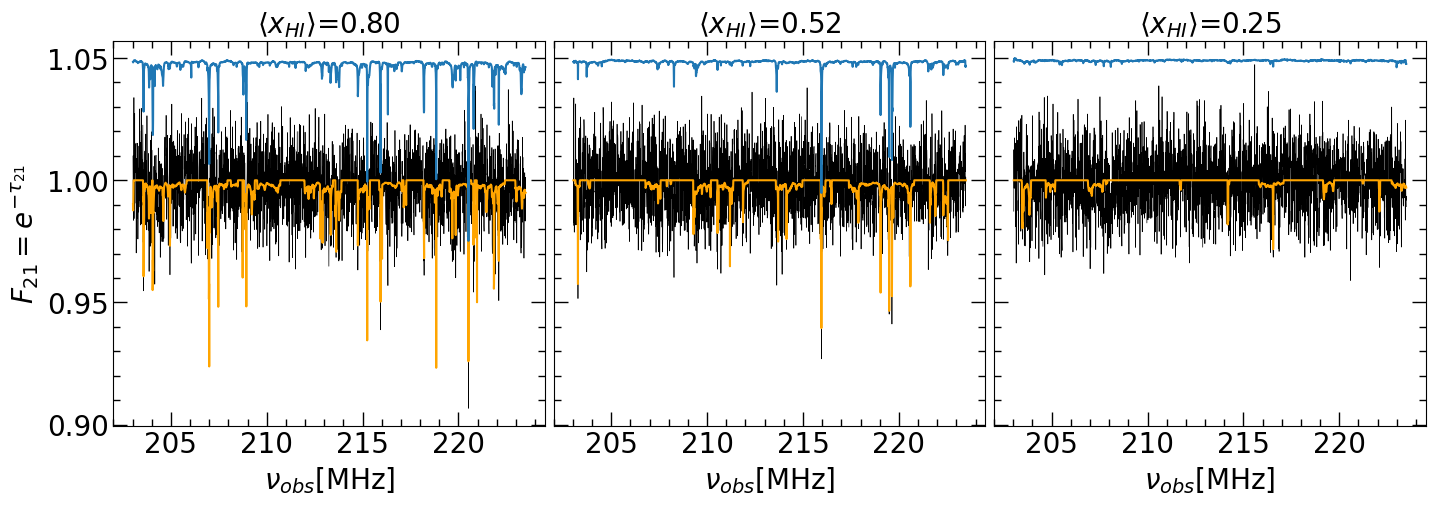


Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)
los1080.shape=(20, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.80: χ²=0.38 χ²=0.04
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.52: χ²=0.37 χ²=0.02
noisy.shape=(2560,)
denoising $\langle x_{HI}\rangle$=0.25: χ²=0.37 χ²=0.01


<Figure size 500x500 with 0 Axes>

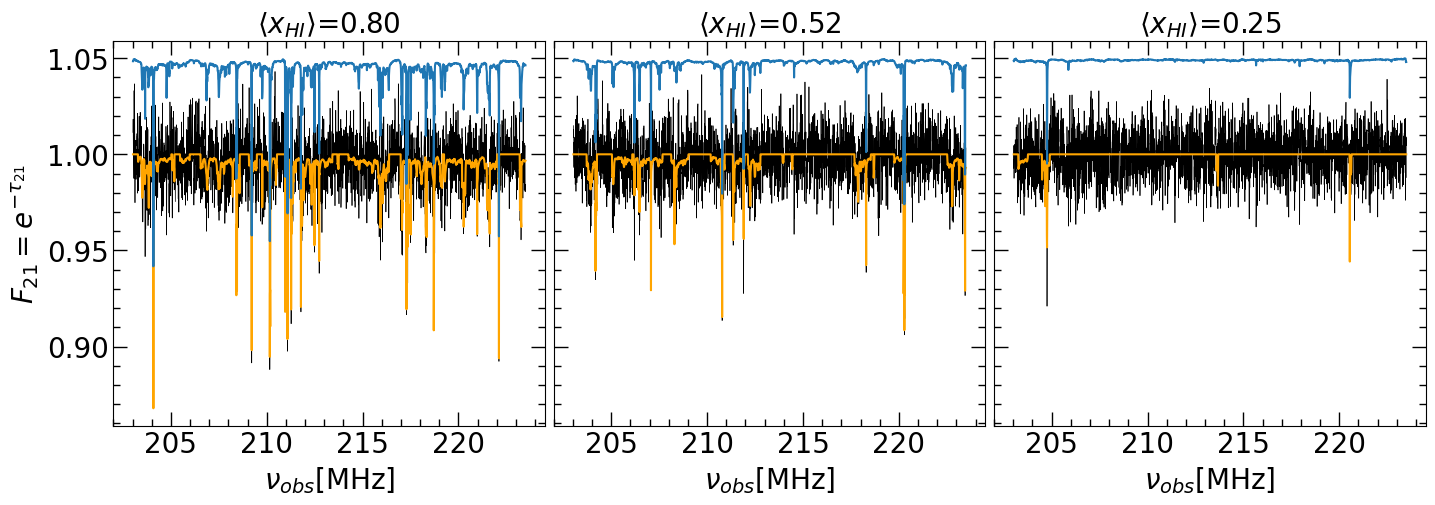

In [18]:
g50denoisedfilepath = '../../../21cm-forest/data/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'

los1080 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.80_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1080so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.80*.dat"), limitsamplesize=2560)
los1080noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.80_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
print(f'los1080.shape={los1080.shape}')
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1052so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52*.dat"), limitsamplesize=2560)
los1052noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)

los1025 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.25_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1025so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.25*.dat"), limitsamplesize=2560)
los1025noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.00_xHI0.25_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
plot_denoised_los_comb([los1080noisy[0], los1052noisy[0], los1025noisy[0]], [los1080so[0],los1052so[0],los1025so[0]], [los1080[0],los1052[0],los1025[0]], showplots=True, saveplots=True, labels=[r'$\langle x_{HI}\rangle$=0.80',r'$\langle x_{HI}\rangle$=0.52',r'$\langle x_{HI}\rangle$=0.25'], tag="1", freq_axis=freq_axis[0]/1e6)

los1080 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.80_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1080so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.80*.dat"), limitsamplesize=2560)
los1080noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.80_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
print(f'los1080.shape={los1080.shape}')
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1052so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52*.dat"), limitsamplesize=2560)
los1052noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)

los1025 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1025so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25*.dat"), limitsamplesize=2560)
los1025noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
plot_denoised_los_comb([los1080noisy[0], los1052noisy[0], los1025noisy[0]], [los1080so[0],los1052so[0],los1025so[0]], [los1080[0],los1052[0],los1025[0]], showplots=True, saveplots=True, labels=[r'$\langle x_{HI}\rangle$=0.80',r'$\langle x_{HI}\rangle$=0.52',r'$\langle x_{HI}\rangle$=0.25'], tag="2", freq_axis=freq_axis[0]/1e6)

los1080 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.80_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1080so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.80*.dat"), limitsamplesize=2560)
los1080noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.80_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
print(f'los1080.shape={los1080.shape}')
los1052 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.52_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1052so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.52*.dat"), limitsamplesize=2560)
los1052noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.52_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)

los1025 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.25_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1025so, freq_axis  = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.25*.dat"), limitsamplesize=2560)
los1025noisy, _ = load_dataset(glob.glob("../../../21cm-forest/data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.00_xHI0.25_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)
plot_denoised_los_comb([los1080noisy[0], los1052noisy[0], los1025noisy[0]], [los1080so[0],los1052so[0],los1025so[0]], [los1080[0],los1052[0],los1025[0]], showplots=True, saveplots=True, labels=[r'$\langle x_{HI}\rangle$=0.80',r'$\langle x_{HI}\rangle$=0.52',r'$\langle x_{HI}\rangle$=0.25'], tag="3", freq_axis=freq_axis[0]/1e6)


Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)


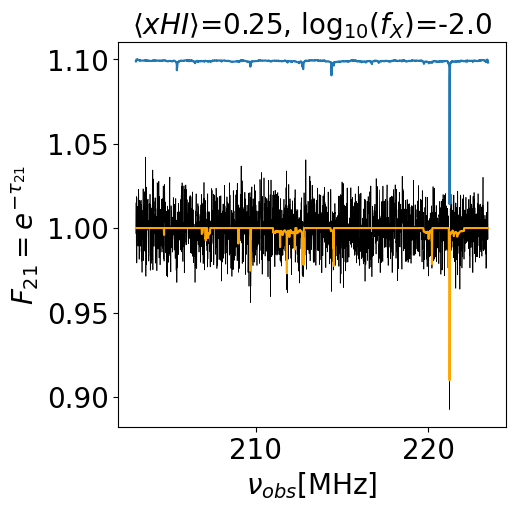

denoising $\langle xHI\rangle$=0.25, log$_{10}(f_X)$=-2.0: χ²=0.37 χ²=0.01


In [109]:
g50denoisedfilepath = '../data/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1025 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1025so, freq_axis  = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25*.dat"), limitsamplesize=2560)
los1025noisy, _ = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.25_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)

pltr.plot_denoised_los(los1025noisy[10:11], los1025so[10:11], los1025[10:11], showplots=True, saveplots=True, label=r'$\langle xHI\rangle$=0.25, log$_{10}(f_X)$=-2.0', freq_axis=freq_axis[0]/1e6)


Combined data shape: (1000, 2560)

Combined data shape: (1000, 2560)


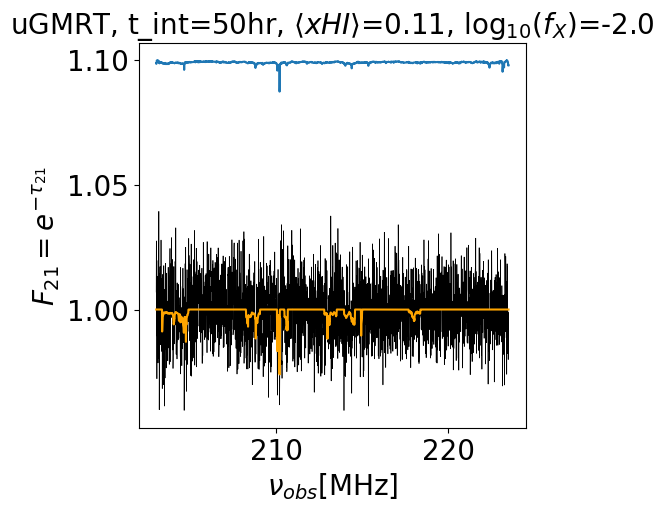

denoising uGMRT, t_int=50hr, $\langle xHI\rangle$=0.11, log$_{10}(f_X)$=-2.0: χ²=0.36 χ²=0.01


In [110]:
g50denoisedfilepath = '../data/denoised_gmrt50h/f21_unet_ps_dum_train_test_uGMRT_t50.0_20250414044023/denoised_los'
los1025 = np.loadtxt(f"{g50denoisedfilepath}/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.11_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.csv")
los1025so, freq_axis  = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.11*.dat"), limitsamplesize=2560)
los1025noisy, _ = load_dataset(glob.glob("../data/21cmFAST_los/F21_noisy/F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.11_uGMRT_8kHz_t50h*.dat"), limitsamplesize=2560)

pltr.plot_denoised_los(los1025noisy[10:11], los1025so[10:11], los1025[10:11], showplots=True, saveplots=False, label=r'uGMRT, t_int=50hr, $\langle xHI\rangle$=0.11, log$_{10}(f_X)$=-2.0', freq_axis=freq_axis[0]/1e6)